Imports

In [1]:
import sys
sys.path.append('..')
import mdtraj

from src.workshop_2_utils import *

from config import settings

Hyperparameters for smina

In [2]:
# smina parameters
num_poses = 1
exhaustiveness = 8

Paths to set

In [3]:
# How many molecules we want to stuff for
num_mols = 2

data_path = settings.data_path / "KIT_wt"

# prepared_protein_pdb_file = data_path / "6vhn_prepared.pdb"
prepared_protein_pdb_file = None
ligand_pdb_file = data_path / "ligand.pdb"

protein_pdbqt_file = data_path / "protein.pdbqt"

save_df_file = data_path / "poses.csv"

In [4]:

smina_inputs_path = data_path / "smina_inputs"
smina_inputs_path.mkdir(exist_ok=True)
smina_outputs_path = data_path / "smina_outputs"
smina_outputs_path.mkdir(exist_ok=True)


We prepare the pdbqt file for the protein

In [5]:
if protein_pdbqt_file is None:
    protein_pdbqt_file = smina_inputs_path / "protein.pdbqt"

    prep=Preprocessor()
    prep.prepare_receptor(prepared_protein_pdb_file, protein_pdbqt_file)

Prepare the bounding box

In [6]:
ligand = mdtraj.load(ligand_pdb_file)
    
def create_box_from_ligand(ligand):
    xyz=ligand.xyz[0]*10 # convert to Angstrom from nm
    pocket_center = (xyz.max(axis=0) + xyz.min(axis=0)) / 2
    pocket_size = xyz.max(axis=0) - xyz.min(axis=0) + 5
    return Box.from_array(pocket_center, pocket_size)

box=create_box_from_ligand(ligand)
box

Box(center=Point(x=-13.045, y=-15.206001, z=34.486), size=Point(x=13.43, y=11.000001, z=14.748001))

Load molecules from Polaris

In [7]:
df_mols = pd.read_csv(settings.dataset_file).drop(columns=['UNIQUE_ID'])
df_mols.head()

,smiles,EGFR_(L858R_mutant),EGFR,KIT_(T6701_mutant),KIT_(V560G_mutant),KIT,RET_(V804L_mutant),RET_(Y791F_mutant),RET,CLASS_EGFR_(L858R_mutant),CLASS_EGFR,CLASS_KIT_(T6701_mutant),CLASS_KIT_(V560G_mutant),CLASS_KIT,CLASS_RET_(V804L_mutant),CLASS_RET_(Y791F_mutant),CLASS_RET
0,O=C(Nc1n[nH]c2cc(-c3ccc(F)cc3)ccc12)C1CC1,4.19,4.27,4.92,0.08,5.10,3.06,2.03,3.73,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,O=C1NC(=O)C(c2ccccc2)=C1Nc1ccccc1,5.64,10.70,8.44,2.76,14.88,8.73,21.57,10.18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,CCn1c(-c2nonc2N)nc2c(C#CC(C)(C)O)ncc(OC3CCNCC3...,2.18,3.18,-0.54,0.39,3.87,4.05,17.13,10.34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,CN(C)c1cc2c(Nc3ccc4c(cnn4Cc4ccccc4)c3)ncnc2cn1,93.40,87.31,-0.32,2.75,3.38,0.35,34.35,13.63,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,NS(=O)(=O)c1ccc(Nc2cc(-c3ccc(O)c(F)c3)n[nH]2)cc1,-2.00,3.68,20.16,55.90,86.43,47.58,55.46,54.96,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [8]:
df_mols['mols'] = df_mols['smiles'].apply(lambda x: Chem.MolFromSmiles(x))
df_mols.head()

,smiles,EGFR_(L858R_mutant),EGFR,KIT_(T6701_mutant),KIT_(V560G_mutant),KIT,RET_(V804L_mutant),RET_(Y791F_mutant),RET,CLASS_EGFR_(L858R_mutant),CLASS_EGFR,CLASS_KIT_(T6701_mutant),CLASS_KIT_(V560G_mutant),CLASS_KIT,CLASS_RET_(V804L_mutant),CLASS_RET_(Y791F_mutant),CLASS_RET,mols
0,O=C(Nc1n[nH]c2cc(-c3ccc(F)cc3)ccc12)C1CC1,4.19,4.27,4.92,0.08,5.10,3.06,2.03,3.73,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,<rdkit.Chem.rdchem.Mol object at 0x7f3edc0f0cf0>
1,O=C1NC(=O)C(c2ccccc2)=C1Nc1ccccc1,5.64,10.70,8.44,2.76,14.88,8.73,21.57,10.18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,<rdkit.Chem.rdchem.Mol object at 0x7f3e7a5760a0>
2,CCn1c(-c2nonc2N)nc2c(C#CC(C)(C)O)ncc(OC3CCNCC3...,2.18,3.18,-0.54,0.39,3.87,4.05,17.13,10.34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,<rdkit.Chem.rdchem.Mol object at 0x7f3e7a5761f0>
3,CN(C)c1cc2c(Nc3ccc4c(cnn4Cc4ccccc4)c3)ncnc2cn1,93.40,87.31,-0.32,2.75,3.38,0.35,34.35,13.63,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,<rdkit.Chem.rdchem.Mol object at 0x7f3e7a576260>
4,NS(=O)(=O)c1ccc(Nc2cc(-c3ccc(O)c(F)c3)n[nH]2)cc1,-2.00,3.68,20.16,55.90,86.43,47.58,55.46,54.96,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,<rdkit.Chem.rdchem.Mol object at 0x7f3e7a5762d0>


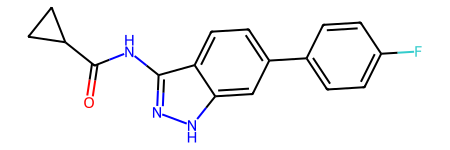

In [9]:
df_mols['mols'][0]

Dock them!

In [10]:
from src.workshop_2_utils import Docking 

docker = Docking(protein_pdbqt_file, box, num_poses=num_poses, exhaustiveness=exhaustiveness) 

if num_mols > len(df_mols):
    num_mols = len(df_mols)

docker.dock_multiple_mols(
        df_mols["mols"].tolist()[:num_mols],
        input_dir = smina_inputs_path,
        output_dir = smina_outputs_path,
        idxs= list(range(num_mols)),
)


2024-06-20 19:46:53.641 | INFO     | src.workshop_2_utils:dock_multiple_mols:266 - Converting mols to pdbqt in '/home/ubuntu/smina/ml4dd/data/KIT_wt/smina_inputs' folder
2024-06-20 19:46:53.703 | INFO     | src.workshop_2_utils:dock_multiple_mols:270 - Docking
100%|██████████| 2/2 [00:12<00:00,  6.22s/it]
2024-06-20 19:47:06.138 | INFO     | src.workshop_2_utils:dock_multiple_mols:279 - Merge all the generated poses together to /home/ubuntu/smina/ml4dd/data/KIT_wt/smina_outputs


Read the poses

In [11]:
poses = dm.read_sdf(smina_outputs_path / "poses.sdf", as_df=True, mol_column="mols", n_jobs=-1)
# poses.sort_values("minimizedAffinity",inplace=True)

Need to get rid of duplicates

In [12]:
if num_poses > 1:
    from rdkit import Chem

    # Function to convert a molecule to its canonical SMILES
    def mol_to_canonical_smiles(mol):
        return Chem.MolToSmiles(Chem.MolFromSmiles(mol), isomericSmiles=True)

    # Apply the function to each molecule in the DataFrame
    poses['canonical_smiles'] = poses['smiles'].apply(mol_to_canonical_smiles)

    # Drop duplicates based on the 'canonical_smiles' column
    poses.drop_duplicates(subset='canonical_smiles', inplace=True)


In [13]:
poses

,smiles,mols,minimizedAffinity
0,O=C1NC(=O)C(c2ccccc2)=C1Nc1ccccc1,<rdkit.Chem.rdchem.Mol object at 0x7f3e2d1ba650>,-7.794343
1,[CH2].[CH3].[C].[O][C]Nc1n[nH]c2cc(-c3ccc(F)cc...,<rdkit.Chem.rdchem.Mol object at 0x7f3e2d1b98c0>,-9.761231


In [14]:
poses.drop(columns=['mols']).to_csv(save_df_file, index=False)